In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path  # - for testing points within boundaries
from tkinter import *  # - saves having to write extra "tk" every time throughout definition. (e.g. "tk.Button" -> "Button")
from tkinter import ttk
import matplotlib.image as mpimg  # - reading image to numpy array
from PIL import Image  # - take image of canvas
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg  # - embed plots in window

#convolution functions to apply simple finite-difference solving
# import scipy.ndimage
# import scipy.signal

# import threading
# import queue

import numba
from numba import jit

try:
    #ghostscript has to be installed and available in the system path
    #supply location to the gs bin file
    import ghostscript
    from PIL import EpsImagePlugin
    EpsImagePlugin.gs_windows_binary = r"C:\Program Files\gs\gs9.55.0\bin\gswin64c.exe"
finally:
    pass

In [23]:
class GUI():
    
    
    def __init__(self,window, canvas_width=500, canvas_height=500):
        self.canvas_width, self.canvas_height = canvas_width, canvas_height
        
        self.window = window
        window.geometry("{0}x{1}".format(self.canvas_width + 700, self.canvas_height + 200))
        window.title("Electric Field Solver - Input and Viewing Screen")
        
        
        #main canvas to draw in/on
#         self.canvas_height, self.canvas_width = 500,500
        self.canvas_frame = Frame(self.window)
        self.canvas_frame.grid(row=1, column=0)
        self.maincanvas = Canvas(self.canvas_frame, height=self.canvas_height, width=self.canvas_width, bg="white", cursor="tcross")
        self.maincanvas.grid(row=0, column=0, padx=(15,5),pady=15, rowspan=7)
        
        #store centre of canvas as x,y
        self.centre = self.canvas_width//2, self.canvas_height//2
        
        #checkbox to toggle axes
        self.axes_toggle = IntVar()
        self.axes_toggle.set(1)
        self.axes_box = Checkbutton(self.canvas_frame, variable=self.axes_toggle, text="Toggle Axes", command=self.draw_axes)
        self.axes_box.grid(row=7, column=0)
        
        #add mini preview canvas
        self.prev_scale = 0.3
        self.prev_height = self.prev_scale * self.canvas_height
        self.prev_width = self.prev_scale * self.canvas_width
        self.mini_canvas = Canvas(self.canvas_frame, height=self.prev_height, width=self.prev_width, bg="gainsboro")
        
#         lineopts = {"dash":(2,2), "width":1}
        self.mini_canvas.create_line(0, self.prev_height//2, self.prev_width, self.prev_height//2, dash=(2,2), width=0.5)
        self.mini_canvas.create_line(self.prev_width//2, 0, self.prev_width//2, self.prev_height, dash=(2,2), width=0.5)
        self.mini_canvas.grid(row=6, column=1, padx=2, pady=(2,15), sticky="SW", columnspan=7)
        
        #buttons and other inputs
        self.buttons_frame = Frame(self.window, height=500, width=300)
        self.buttons_frame.grid(row=1, column=1, padx=(15,0), sticky="NEWS", columnspan=8, rowspan=5)
#         self.buttons_frame.columnconfigure(0, weight=1)
        
        self.quitbutton = Button(self.buttons_frame, text="Quit", width=10, height=2, bg="gainsboro", font=("Calibri",12,"bold","underline"), foreground="darkred", command=window.destroy)
        self.quitbutton.grid(row=0, column=10, sticky="NE", padx=50, pady=(15,0), columnspan=3, rowspan=1)
        self.quitbutton["borderwidth"] = 1.5
        self.quitbutton["relief"] = "groove"
        
        #button to clear canvas
        self.clearbutton = Button(self.canvas_frame, text="Clear Canvas", width=12, height=2, bg="whitesmoke", font=("Calibri",11), command=self.clear_canvas)
        self.clearbutton.grid(row=0, column=1, sticky="WE", padx=(2,5), pady=0, columnspan=3)
        self.clearbutton["borderwidth"] = 0.5
        self.clearbutton["relief"] = "ridge"
        
        #button to begin processing of input canvas (outputting arrays)
        self.processbutton = Button(self.buttons_frame, text="Process Canvas", width=26, height=4, bg="whitesmoke", font=("Calibri", 11), command=self.output_arrays)
        self.processbutton.grid(row=10, column=0, sticky="SWE", padx=(0,0), pady=10, columnspan=10)
        self.processbutton["borderwidth"] = 0.5
        self.processbutton["relief"] = "ridge"
        
        #additional button ??
#         self.process2 = Button(self.window, text="Additional Processing?", width=30, height=2)
#         self.process2.grid(row=1, column=1, sticky="SWE", padx=(15,0), pady=45)
        
        #separator line on window
        self.frame_separator = ttk.Separator(self.buttons_frame, orient="horizontal")
        self.frame_separator.grid(row=9, column=0, pady=(50,5), sticky="SEW", columnspan=10)
        
        
        self.frame_separator_vert = ttk.Separator(self.canvas_frame, orient="vertical")
        self.frame_separator_vert.grid(row=0, column=20, padx=(8,50), pady=(25,0), sticky="NES", rowspan=7)
        
        #scroll-wheels selection for Red, Green, Blue colour values
        #text box for potential value setting
        
        #add validation functions for rgb entries
        #spinbox will choose from given values only
        #however, users can type any text - filter out non-integer values; and truncate anything outside [0,255] range
        self.redbox = Spinbox(self.buttons_frame, values=[_ for _ in range(0,255+1)], repeatinterval=10, width=5, command=self.draw_preview)
        self.greenbox = Spinbox(self.buttons_frame, values=[_ for _ in range(0,255+1)], repeatinterval=10, width=5, command=self.draw_preview)
        self.bluebox = Spinbox(self.buttons_frame, values=[_ for _ in range(0,255+1)], repeatinterval=10, width=5, command=self.draw_preview)
        
        #labels and placement
        self.redlabel = Label(self.buttons_frame, text="Red")
        self.greenlabel = Label(self.buttons_frame, text="Green")
        self.bluelabel = Label(self.buttons_frame, text="Blue")
        self.redbox.grid(row=1, column=1, padx=1)
        self.greenbox.grid(row=1, column=2, padx=1)
        self.bluebox.grid(row=1, column=3, padx=1)
        self.redlabel.grid(row=0, column=1, padx=1, sticky="S")
        self.greenlabel.grid(row=0, column=2, padx=1, sticky="S")
        self.bluelabel.grid(row=0, column=3, padx=1, sticky="S")
        
        #potential entry box
        #will need validation for negative entries, thus should use string entries
        #convert afterward to extract numerical value
        self.current_potential = StringVar()
        self.current_potential.set("0")
        self.potentialbox = Entry(self.buttons_frame, textvariable=self.current_potential, width=10, justify="right")
        self.potentiallabel = Label(self.buttons_frame, text="Electric Potential")
        self.Vlabel = Label(self.buttons_frame, text=" V")
        self.potentialbox.grid(row=1, column=4, padx=3, sticky="E")
        self.potentiallabel.grid(row=0, column=4, sticky="SE", columnspan=2)
        self.Vlabel.grid(row=1, column=5, sticky="W")
        
        #validation bindings
        self.redbox.bind("<FocusOut>", lambda event, colour="Red": self.validate_rgb(event, colour))
        self.greenbox.bind("<FocusOut>", lambda event, colour="Green": self.validate_rgb(event, colour))
        self.bluebox.bind("<FocusOut>", lambda event, colour="Blue": self.validate_rgb(event, colour))
        self.potentialbox.bind("<FocusOut>", self.validate_potential)
        
#         self.redbox["highlightbackground"] = "red"
#         self.redbox["highlightthickness"] = 1.5
#         self.greenbox["highlightbackground"] = "green"
#         self.greenbox["highlightthickness"] = 1.5
#         self.bluebox["highlightbackground"] = "blue"
#         self.bluebox["highlightthickness"] = 1.5
        
        
        #drop-down menu for shape/draw type
        shape_options = ["Rectangle","Oval","Triangle","Freehand Line"]
        self.selected_shape = StringVar()
        self.shape_list = ttk.Combobox(self.buttons_frame, textvariable=self.selected_shape.get(), width=25, state="readonly")
        self.shape_list["values"] = shape_options
        self.shape_list.current(0)  # - set to index 0 of given options - i.e. shape_options[0]
        self.shape_list.grid(row=3, column=0, padx=0, pady=20, sticky="WE", columnspan=6, rowspan=3)
        self.shape_list.bind("<FocusOut>", lambda event: self.draw_preview())  # - change callback to update preview
        
        #checkbox to toggle boundary True/False
        self.boundary_toggle = IntVar()
        self.boundary_toggle.set(1)
        self.bd_cond_box = Checkbutton(self.buttons_frame, variable=self.boundary_toggle, text="Set Boundary")
        self.bd_cond_box.grid(row=3, column=4, sticky="EW", columnspan=6, rowspan=3)
                
        
        
        #event bindings
        #create custom functions for focus leaving a widget
        #this can include validation checks alongside
        window.bind_all("<Button-1>", self.click_focus)
        window.bind_all("<Return>", lambda event: self.window.focus_set())
        self.shape_list.bind("<Leave>", self.click_focus)
        
        
        #canvas bindings
        self.maincanvas.bind("<Motion>", lambda event: self.draw_outline(event))
        self.maincanvas.bind("<Leave>", lambda event: self.maincanvas.delete("outline"))
        self.maincanvas.bind("<Button-1>", lambda event: self.draw_shape(event))
        self.maincanvas.bind("<B1-Motion>", lambda event: self.draw_shape(event))
        
        #mini-canvas
        #add entries for: rotation, height and width
        #localised at similar frame location to self.mini_canvas
        self.width = StringVar()
        self.height = StringVar()
        self.width.set("100")
        self.height.set("100")
        self.anglebox = Spinbox(self.canvas_frame, values=[_ for _ in range(0,360+1)], width=4, repeatinterval=10, command=self.validate_angle)
        self.widthbox = Entry(self.canvas_frame, textvariable=self.width, width=5)
        self.heightbox = Entry(self.canvas_frame, textvariable=self.height, width=5)
        self.anglelabel = Label(self.canvas_frame, text="Rotation:")
        self.widthlabel = Label(self.canvas_frame, text="W:")
        self.heightlabel = Label(self.canvas_frame, text="H:")
        
        self.anglebox.grid(row=6, column=2, padx=0, pady=(20,0), sticky="NW")
        self.widthbox.grid(row=7, column=1, padx=0, pady=0, sticky="NE")
        self.heightbox.grid(row=7, column=4, padx=0, pady=0, sticky="NW")
        self.anglelabel.grid(row=6, column=1, padx=0, pady=(20,0), sticky="NW")
        self.widthlabel.grid(row=7, column=1, padx=0, sticky="NW")
        self.heightlabel.grid(row=7, column=3, padx=0, sticky="NW")
        
        self.anglebox.bind("<FocusOut>", self.validate_angle)
        self.widthbox.bind("<FocusOut>", self.validate_dimensions)
        self.heightbox.bind("<FocusOut>", self.validate_dimensions)
        
        
        
        #finish any other setup needed
        #toggle axes on by default
        if self.axes_toggle.get() == 1:
            self.draw_axes()
        self.draw_preview()
        
        #potential array setup
        self.maskarray = np.zeros((self.canvas_width, self.canvas_height)).T
        self.potentialarray = np.zeros((self.canvas_width, self.canvas_height)).T
        
        #output
        #invert mask array so that 1 corresponds to background and 0 the boundaries (shapes)
        #then can output to txt files
        
        return ###### __init__ end ######
    
    
    def click_focus(self, event):
        if event.type == EventType.ButtonPress:
            #coordinates location only applies on button click
            
            #check if the click was anywhere outside the focused widget
            #if outside, remove focus by switching to focus on the window itself
            x,y = self.window.winfo_pointerxy()
            try:
                widget = self.window.winfo_containing(x,y)
                if widget != self.window.focus_get():
                    self.window.focus_set()
            except:  # - needed because winfo_containing has KeyError issues with dropdown
                pass
            
        return
    
    
    def draw_axes(self):
        if self.axes_toggle.get() == 0:
            self.maincanvas.delete("axis")
            
        elif self.axes_toggle.get() == 1:
            #add axes onto the main canvas
            #this will be performed whenever the canvas is cleared, if axes are still toggled on

            lineopts = {"dash":(2,2), "width":1}
            #horizontal axis line at central y-value
            self.maincanvas.create_line(0, self.centre[1], self.canvas_width, self.centre[1], tags="axis", **lineopts)
            #vertical axis line at central x-value
            self.maincanvas.create_line(self.centre[0], 0, self.centre[0], self.canvas_height, tags="axis", **lineopts)
        
        return
    
    
    def clear_canvas(self):
        #remove everything, but maintain axes
        #another way to specify ? - e.g. all tags except "axis" ?
        
        self.maincanvas.delete("all")
        if self.axes_toggle.get() == 1:
            self.draw_axes()
            
        self.maskarray = np.zeros((self.canvas_width, self.canvas_height)).T
        self.potentialarray = np.zeros((self.canvas_width, self.canvas_height)).T
        return
    
    
    def draw_preview(self):
        #display preview of loaded shape on mini-canvas
        
        #preview canvas centre
        previewcentre = self.prev_width//2, self.prev_height//2
        
        #get parameters for shape
        shape = self.shape_list.get()
        angle = int(self.anglebox.get())
        height = self.prev_scale * int(self.heightbox.get())
        width = self.prev_scale * int(self.widthbox.get())
        drawcolour = self.get_colour(self.redbox.get(), self.greenbox.get(), self.bluebox.get())
        draw_opts = {"fill":drawcolour, "width":0, "tags":"preview"}
        
        
        self.mini_canvas.delete("preview")
        if shape == "Freehand Line":  # - no preview can be drawn for freehand
            #also doesn't work as a boundary
            #grey out the boundary toggle option
            #re-enable when shape changes
            self.bd_cond_box.config(state = DISABLED)
            return
        
        #re-enable boundary conditions toggle if not freehand line drawing
        self.bd_cond_box.config(state = ACTIVE)
        
        
        #check the rest
        #others drawn by coordinate bounding boxes - (x0,y0,x1,y1)
        #### - NOTE: actually can't seem to rotate shapes unless they are polygons
        #### - may need to manually define rectangles, ovals etc. so that they can be updated with canvas.coords()
        #if non-zero angle, a rotation of these coords should be applied (complex numbers)
        
        #define bounding box (corners of shape to be drawn)
        #assume centred at zero for now, so that they can be rotated as is
        x_0,y_0 = previewcentre[0] - width//2, previewcentre[1] - height//2
        x_1,y_1 = previewcentre[0] + width//2, previewcentre[1] + height//2
        
        
        if shape == "Oval":
            #add shape, centred but scaled down by the relative size of the mini-canvas
            #have to approximate an oval by polygon
            #so need points (roughly) around all the angles, and scaled properly by major/minor axis
            major_ax = (x_1 - x_0)//2
            minor_ax = (y_1 - y_0)//2
            
            coords = []
#             for i in range(360):
                #scale by projections of circle (2pi radians) onto axes
                #and factor in major/minor lengths
#             angle_step = (i/360) * 2*np.pi
            angle_step = (np.arange(360) / 360) * 2*np.pi

            x_oval = major_ax * np.cos(angle_step)
            y_oval = minor_ax * np.sin(angle_step)

#             coords.append(x_oval + previewcentre[0])
#             coords.append(y_oval + previewcentre[1])
            coords = list(np.c_[x_oval + previewcentre[0], y_oval + previewcentre[1]].ravel())
                
            coords = self.rotate_coords(coords, angle, centre=previewcentre)
            
        elif shape == "Triangle":
            coords = [x_0,y_1, previewcentre[0],y_0, x_1,y_1]
            coords = self.rotate_coords(coords, angle, centre=previewcentre)
            
        elif shape == "Rectangle":
            #manually set 4 corner points as polygon
            coords = [x_0,y_0, x_0,y_1, x_1,y_1, x_1,y_0]
            coords = self.rotate_coords(coords, angle, centre=previewcentre)
            
            
        #all shapes created as polygons to allow rotation
        drawn_preview = self.mini_canvas.create_polygon(*coords, **draw_opts)
        return
    
    
    def draw_outline(self, event):
        #preview outline of shape around mouse pointer
        
        #get parameters for shape
        shape = self.shape_list.get()
        angle = int(self.anglebox.get())
        height = int(self.heightbox.get())
        width = int(self.widthbox.get())
        drawcolour = self.get_colour(self.redbox.get(), self.greenbox.get(), self.bluebox.get())
        draw_opts = {"outline":drawcolour, "fill":"", "width":1, "dash":(2,2), "tags":"outline"}
        
        if shape == "Freehand Line":  # - no preview can be drawn for freehand
            return
        
        #check the rest
        #others drawn by coordinate bounding boxes - (x0,y0,x1,y1)
        #if non-zero- angle, a rotation of these coords should be applied (complex numbers)
        x_0, y_0 =  event.x - width//2, event.y - height//2
        x_1, y_1 =  event.x + width//2, event.y + height//2
        
        
        self.maincanvas.delete("outline")
        if shape == "Oval":
            major_ax = (x_1 - x_0)//2
            minor_ax = (y_1 - y_0)//2
            
            coords = []
#             for i in range(360):
                #scale by projections of circle (2pi radians) onto axes
                #and factor in major/minor lengths
#             angle_step = (i/360) * 2*np.pi
            angle_step = (np.arange(360) / 360) * 2*np.pi

            x_oval = major_ax * np.cos(angle_step)
            y_oval = minor_ax * np.sin(angle_step)

#             coords.append(x_oval + event.x)
#             coords.append(y_oval + event.y)
            coords = list(np.c_[x_oval + event.x, y_oval + event.y].ravel())
                          
            coords = self.rotate_coords(coords, angle, centre=[event.x,event.y])
        elif shape == "Triangle":
            coords = [x_0,y_1, event.x,y_0, x_1,y_1]
            coords = self.rotate_coords(coords, angle, centre=[event.x,event.y])
            
        elif shape == "Rectangle":
            #manually set 4 corner points as polygon
            coords = [x_0,y_0, x_0,y_1, x_1,y_1, x_1,y_0]
            coords = self.rotate_coords(coords, angle, centre=[event.x,event.y])
            
            
        #all shapes created as polygons to allow rotation
        drawn_preview = self.maincanvas.create_polygon(*coords, **draw_opts)
        return
    
    
    def draw_shape(self, event):
        #add shape to canvas based on set values
        #exactly like the outline, but with fill and no border
        #add tags (???) - possibility of "undo" function?
        
        #get parameters for shape
        shape = self.shape_list.get()
        angle = int(self.anglebox.get())
        height = int(self.heightbox.get())
        width = int(self.widthbox.get())
        drawcolour = self.get_colour(self.redbox.get(), self.greenbox.get(), self.bluebox.get())
        draw_opts = {"outline":drawcolour, "fill":drawcolour, "width":1, "tags":"shape"}
        
        if shape == "Freehand Line":
            #on initial click, need to store the clicked location
            #next point along line will be drawn from here to the next <Motion> event
            if event.type == EventType.ButtonPress:
                self.prev_x, self.prev_y = event.x, event.y
            self.draw_freehand(event)
            return
        
        #check the rest
        #others drawn by coordinate bounding boxes - (x0,y0,x1,y1)
        #if non-zero- angle, a rotation of these coords should be applied (complex numbers)
        x_0, y_0 =  event.x - width//2, event.y - height//2
        x_1, y_1 =  event.x + width//2, event.y + height//2
        
        
        if shape == "Oval":
            major_ax = (x_1 - x_0)//2
            minor_ax = (y_1 - y_0)//2
            
            coords = []
#             for i in range(360):
                #scale by projections of circle (2pi radians) onto axes
                #and factor in major/minor lengths
#             angle_step = (i/360) * 2*np.pi
            angle_step = (np.arange(360) / 360) * 2*np.pi

            x_oval = major_ax * np.cos(angle_step)
            y_oval = minor_ax * np.sin(angle_step)

#             coords.append(x_oval + event.x)
#             coords.append(y_oval + event.y)
            coords = list(np.c_[x_oval + event.x, y_oval + event.y].ravel())
                          
            coords = self.rotate_coords(coords, angle, centre=[event.x,event.y])
        elif shape == "Triangle":
            coords = [x_0,y_1, event.x,y_0, x_1,y_1]
            coords = self.rotate_coords(coords, angle, centre=[event.x,event.y])
            
        elif shape == "Rectangle":
            #manually set 4 corner points as polygon
            coords = [x_0,y_0, x_0,y_1, x_1,y_1, x_1,y_0]
            coords = self.rotate_coords(coords, angle, centre=[event.x,event.y])
            
            
        #all shapes created as polygons to allow rotation
        drawn_shape = self.maincanvas.create_polygon(*coords, **draw_opts)
        
        #put axes on top so they can be seen at all times
        if self.axes_toggle.get() == 1:
            self.maincanvas.tag_raise("axis", "all")
        
        self.add_new_potential()
        return
    
    
    def draw_freehand(self, event):
        #allow updating of freehand line as mouse is dragged on screen
        drawcolour = self.get_colour(self.redbox.get(), self.greenbox.get(), self.bluebox.get())
        opts = {"fill":drawcolour, "width":1, "tags":"shape"}
        
        self.maincanvas.create_line(self.prev_x, self.prev_y, event.x, event.y, **opts)
        
        #update this event's position to become the new prev point
        self.prev_x, self.prev_y = event.x, event.y
        
        return
    
    
    def validate_rgb(self, event, colour):
        #check contents in r,g,b spinboxes upon focus leave
        rgb_boxes = {"Red":self.redbox, "Green":self.greenbox, "Blue":self.bluebox}
        box = rgb_boxes[colour]
        
        user_entry = box.get()
        try:
            user_entry = int(user_entry)
        except:
            replacement = 0
                
        if isinstance(user_entry, int):
            if user_entry > 255:
                replacement = 255
            elif user_entry < 0:
                replacement = 0
            else:
                replacement = user_entry
        
        box.delete(0, END)
        box.insert(0, replacement)
        
        self.draw_preview()
        return
    
    
    def validate_potential(self, event=None):
        #ensure potential is either negative, zero, or positive
        #and it can also be a float value
        user_entry = self.potentialbox.get()
        
        #if not able to convert to float, the entry is invalid and is reset to zero
        try:
            user_entry = float(user_entry)
        except:
            replacement = 0
            self.potentialbox.delete(0, END)
            self.potentialbox.insert(0, replacement)
        
        self.draw_preview()
        return
    
    
    def validate_angle(self, event=None):
        #ensure entry in anglebox is numeric, integer in range [0,360]
        #number can be out of that range, then convert into that range (e.g. 720 === 360)
        user_entry = self.anglebox.get()
        
        try:
            user_entry = int(user_entry)
            replacement = user_entry % 360  
            
        except:
            replacement = 0
        
        self.anglebox.delete(0, END)
        self.anglebox.insert(0, replacement)
        
        self.draw_preview()        
        return
    
    
    def validate_dimensions(self, event):
        #for width and height setting
        #should be positive integers
        #possibly set an upper limit to prevent lag when drawing
        #i.e. hypotenuse of canvas
        box = event.widget        
        user_entry = box.get()
        try:
            user_entry = int(user_entry)
            if user_entry < 0:
                user_entry = abs(user_entry)
                
            replacement = user_entry
        except:
            replacement = "100"  # - default value
        
        box.delete(0, END)
        box.insert(0, replacement)
        
        self.draw_preview()
        return
    
    
    def rotate_coords(self, coords, angle, centre=None):
        #apply simple rotation in complex plane
        #retrieve new coords from rotated complex value
        if centre is None:
            centre = [0,0]
        
        #apply e^ix rotation in complex plane, with angular fraction included
        #remove offset from coords - to rotate around origin
        #add back afterwards
        x_complex = np.array(coords[::2]) * complex(1,0)  - centre[0]
        y_complex = np.array(coords[1::2]) * complex(0,1)  - (centre[1] * 1j)
        
        rotated_points = (x_complex + y_complex) * np.exp(1j * (angle/360) * 2*np.pi)
        x_new, y_new = rotated_points.real + centre[0], rotated_points.imag + centre[1]
        
        new_coords = np.c_[x_new, y_new].ravel()  # - recombine the np arrays to alternating x,y pairs
        
        return new_coords
    
    
    def get_colour(self, r,g,b):
        #supply rgb values and get a hex colour code in return
        r,g,b = [int(colour) for colour in (r,g,b)]
        return "#%02x%02x%02x" % (r,g,b)
    
    
    def add_new_potential(self):
        #create array for a new shape, then add it to total array
        #NOTE: not sure how to make work with freehand line, as they have no coords() to access
        potential = float(self.potentialbox.get())
        
        shape_bounds = self.maincanvas.coords("current")
        if not shape_bounds:
            return            
        shape_bounds = list(zip(shape_bounds[::2], shape_bounds[1::2]))  # - specific (x,y) tuple format needed for Path

        test_grid = np.vstack(np.indices((self.canvas_width, self.canvas_height)).T)  # - specific Nx2 format needed for Path
        shape_mask = Path(shape_bounds).contains_points(test_grid, radius=1).reshape(self.canvas_height, self.canvas_width)
        
        
        #generate potential array by multiplying individual mask, and add this to main potential array
        #checks needed to remove overlaps
        shape_potential = potential * shape_mask  # - as shape_mask is Boolean (1/0), multiplying 1s to give potential; zero elsewhere
        
        #summed arrays to update
        #manually reset the invalid values (i.e. overlaps - where mask > 1)
        #also for potentials, check if overlap's total value is greater than current potential, overwrite with this value
        self.maskarray += shape_mask
        
        #check if setting to boundary (1) or background (0)
        #then reset mask and put potential back to zero (background)
        if self.boundary_toggle.get() == 0:
            self.maskarray[shape_mask] = 0
            self.potentialarray[shape_mask] = 0
        else:
            #flag points as boundary conditions
            self.maskarray[self.maskarray > 1] = 1
            
            #add the new potential
            #check if the added points came to a total sum not equal to the current potential - then values should be reset manually
            self.potentialarray += shape_potential
            self.potentialarray[(shape_mask == True) & (self.potentialarray != potential)] = potential
        
        
        return
    
    
    def finite_difference(self):
        #use a simple finite-difference process using the average of 4 neighbouring points
        #combine with error tolerance to use the "Jacobi" iteration scheme
        #calculate the numerical values which satisfy Laplace's equation in 2D
        #for the initial boundaries provided
        #the finite-difference equation can be performed as a convolution with a 3x3 kernel of weights for each grid point
        
        maskarray = 1 - self.maskarray.copy()
        potentialarray = self.potentialarray.copy()
        
        conv_factor = 1 * np.array([[0, 1/4, 0], [1/4, 0, 1/4], [0, 1/4, 0]])
        
        v_q_plus = potentialarray.copy()
        while True:
            v_q = v_q_plus.copy()

            v_q_plus[maskarray == True] = scipy.ndimage.convolve(v_q, conv_factor, mode="nearest")[maskarray == True]
#             v_q_plus[maskarray == True] = scipy.signal.convolve(v_q, conv_factor, mode="same", method="fft")[maskarray == True]

            if np.allclose(v_q_plus, v_q, rtol=1e-4):
                break
        
        self.final_potentials = v_q_plus.copy()
        
        return
    
    @staticmethod
    @jit(parallel=True)
    def sor(maskarray, potentialarray, f=1, rtol=1e-4, boundary="fixed"):
        #successive over-relaxation method
        #using a relaxation parameter "f" to apply weighting to current point vs other points in 5-point stencil
        #f should default to 1 - this is simple Gauss-Seidel; however for quickest results we aim for high f < 2
        #along with Gauss-Seidel selection - using updated points as soon as available
        #speed up using numba.jit - caching the processes to be executed much faster
        #accelerate using parallel execution via numba - numba.prange() replaces python's range()
        
        v_q_plus = potentialarray.copy()
        ny,nx = v_q_plus.shape
        while True:
            v_q = v_q_plus.copy()
            
            if boundary == "periodic":
                for k in numba.prange(ny):
                    #set edge cases manually to wrap-around to other side of array ("periodic" boundary conditions)
                    up, down = k+1, k-1  # - standard values for interior points
                    if k == 0:
                        up, down = -1, 1
                    if k == ny-1:
                        up, down = -2, 0

                    for l in numba.prange(nx):
                        left, right = l-1, l+1
                        if l == 0:
                            left, right = -1, 1
                        if l == nx-1:
                            left, right = -2, 0


                        #apply the 5-point stencil
                        if maskarray[k,l] == True:
                            v_q_plus[k,l] = (1-f) * v_q_plus[k,l] \
                                            + f/4 * (v_q_plus[k,left] + v_q_plus[k,right] + v_q_plus[down,l] + v_q_plus[up,l])
            
            
            elif boundary == "fixed":
                #avoid any modification of edge points, process available points without using "ghost" points
                for k in numba.prange(1,ny-1):
                    for l in numba.prange(1,nx-1):
                        if maskarray[k,l] == True:
                            up, down = k+1, k-1
                            left, right = l+1, l-1
                            
                            
                            #apply the 5-point stencil
                            v_q_plus[k,l] = (1-f) * v_q_plus[k,l] \
                                            + f/4 * (v_q_plus[k,left] + v_q_plus[k,right] + v_q_plus[down,l] + v_q_plus[up,l])
                            
                            
                        
            #explicit implementation of np.allclose, which seems not to be usable by numba.jit
            #check relative change by all points - if all are below the tolerance level: finish
            if np.less_equal(np.abs(v_q_plus - v_q), rtol * np.abs(v_q)).all():
                break
        
        return v_q_plus.copy()
    
    
    def get_Efield(self):
        #having processed for the numerical values of potential across the grid
        #now interested in getting the electric field shape, E = - grad(V)
        
        gradV = np.gradient(self.final_potentials, axis=(1,0))
        self.Efield = [-gradV[0], -gradV[1]]
        
        return
    
    
    def output_arrays(self):
        #once canvas finished, can save the arrays to txt files for processing in electric field solver
        #mask array is output with background at 1 and boundaries at 0
        #by convention of the rest of the program - editable points are "True" (1)
        
        self.processbutton.configure(text="Solving for potential values...")
        self.window.update()
        
        np.savetxt("maskarray.txt", 1 - self.maskarray, delimiter=" ", fmt="%f")
        np.savetxt("potentialarray.txt", self.potentialarray, delimiter=" ", fmt = "%f")
        
        #process inputs of initial/boundary conditions
        
#         self.finite_difference()
        self.final_potentials = self.sor(1 - self.maskarray, self.potentialarray, f=1.9825, rtol=1e-4, boundary="periodic")
        self.processbutton.configure(text="Getting the electric field...")
        self.window.update()
        self.get_Efield()
        
        self.processbutton.configure(text="Process Canvas")
        self.window.update()

        #save postscipt image and convert to a png to be read in
        #if possible, but if ghostscript is not installed we move on without the image
        try:
            filename = "tk_canvas"
            self.maincanvas.postscript(file = filename + '.eps', pagewidth=self.canvas_width-1, pageheight=self.canvas_height-1) 
            # use PIL to convert to PNG
            img = Image.open(filename + '.eps') 
            img.save(filename + '.png', 'png')
        except:
            pass            
        finally:
        
#         x = self.window.winfo_rootx() + self.maincanvas.winfo_x()
#         y = self.window.winfo_rooty() + self.maincanvas.winfo_y()
#         x1 = x + self.maincanvas.winfo_width()
#         y1 = y + self.maincanvas.winfo_height()
#         print(x,y)
#         print(x1,y1)
#         ImageGrab.grab().crop((x+50,y+50,x1+100,y1+100)).save("tk_canvas.png")
    
    
            #would add callback (either to this function or from this function) to run processing for rest of solver
            #i.e. the "control system", which begins from a button on canvas and outputs into the GUI
            self.outputwindow = Toplevel(self.window)
            self.outputwindow.title("Calculated Electric Field")
            self.outputwindow.geometry("{0}x{1}+0+0".format(self.canvas_width + 200, self.canvas_height + 200))

            self.savebutton = Button(self.outputwindow, text="Save Output Plot", bg="gainsboro", font=("Calibri",11), command = lambda: plt.savefig("Efield.png"))
            self.savebutton.grid(row=2,column=1)
            self.savebutton["borderwidth"] = 0.5
            self.savebutton["relief"] = "ridge"


            fig = plt.figure(figsize=(self.canvas_width/100,self.canvas_height/100), dpi=100)
            ax = fig.add_subplot(111)

            #draw user's input image
            #attempt to use the original image
            #but since tkinter is awkward with saving canvas, may have errors if ghostscript not installed (add earlier check)
            #use the mask array as a backup to overlay the field lines
            try:
                img = mpimg.imread("tk_canvas.png")
                ax.imshow(img)
            except:
                ax.imshow(1 - self.maskarray)

            #overlay the streamplot of E-field vector lines
            x = np.arange(0, self.final_potentials.shape[1])
            y = np.arange(0, self.final_potentials.shape[0])
            X,Y = np.meshgrid(x,y)
            ax.streamplot(X,Y, *self.Efield, linewidth=0.5, density=1)


            self.output_canvas = FigureCanvasTkAgg(fig, master=self.outputwindow)
            self.output_canvas.draw()
            self.output_canvas.get_tk_widget().grid(row=1, column=1, sticky="NEWS")
        
        
        return

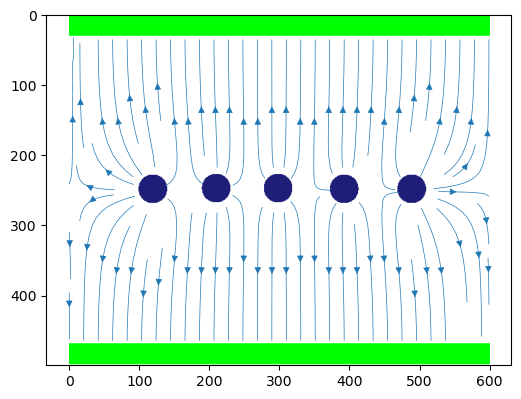

In [24]:
#use the class to define the window, then run as shown below
root = Tk()
g = GUI(root, 600, 500)
root.mainloop()

In [25]:
#check output arrays (saved to .txt files)
maskarray = np.loadtxt("maskarray.txt", delimiter=" ")
potentialarray = np.loadtxt("potentialarray.txt", delimiter=" ")

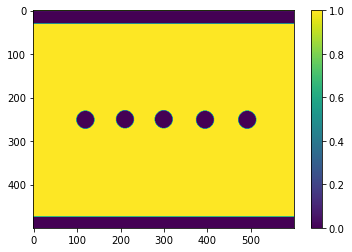

In [26]:
#view mask array
# - True (1) for background points which can be edited
# - False (0) for boundary points which must stay constant
plt.imshow(maskarray)
plt.colorbar()
plt.show()

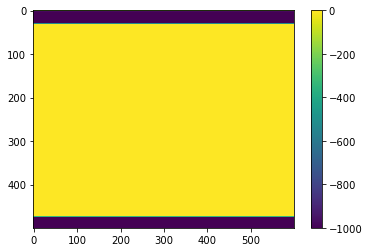

In [27]:
#view potential array
# - values stored on potential boundaries
# - the mask array differentiates the boundary zeros from background zeros, as seen by comparing the two array plots shown
plt.imshow(potentialarray)
plt.colorbar()
plt.show()

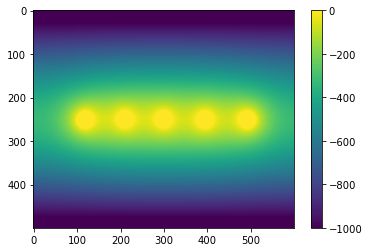

In [28]:
#view of the potential values that were solved for across the grid using finite difference processing
#where initial/boundary conditions had all zeros away from boundaries; now the entire field is approximately known
plt.imshow(g.final_potentials)
plt.colorbar()
plt.show()

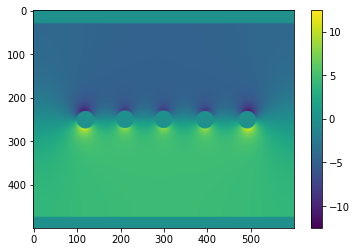

In [31]:
#example of the E-field coefficients (in y-direction) that describe the field behaviour
#calculated by taking the negative of the vector gradient applied to the final_potentials grids
plt.imshow(g.Efield[1])
plt.colorbar()
plt.show()